In [49]:
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as R

data = pd.read_csv('log/data_sensor_new.csv')
data.columns

Index(['Time [s]', 'Acceleration X [m/s^2]', 'Acceleration Y [m/s^2]',
       'Acceleration Z [m/s^2]', 'Angular velocity X [rad/s]',
       'Angular velocity Y [rad/s]', 'Angular velocity Z [rad/s]',
       'Quaternion X', 'Quaternion Y', 'Quaternion Z', 'Quaternion W',
       'Velocity X [m/s]', 'Velocity Y [m/s]'],
      dtype='object')

In [51]:
accelerations = data[['Acceleration X [m/s^2]', 'Acceleration Y [m/s^2]', 'Acceleration Z [m/s^2]']].to_numpy()*9.81
velocities = data[['Velocity X [m/s]', 'Velocity Y [m/s]']].to_numpy()*10
angular_velocity = data[['Angular velocity X [rad/s]', 'Angular velocity Y [rad/s]', 'Angular velocity Z [rad/s]']].to_numpy()
quaternions = data[['Quaternion X', 'Quaternion Y', 'Quaternion Z', 'Quaternion W']].to_numpy()
times = data['Time [s]'].to_numpy()

In [66]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=times, y=accelerations[:, 0], mode='lines', name='Acceleration X'))
fig.add_trace(go.Scatter(x=times, y=velocities[:, 1], mode='lines', name='Acceleration Y'))

## Most basic: Direct integration without any compensation

In [52]:
est_velocities = [np.array([0, 0])]
est_positions_imu = [np.array([0, 0])]
est_positions_flow = [np.array([0, 0])]

for i in range(1, len(accelerations)):
    dt = times[i] - times[i-1]
    acc = 0.5*(accelerations[i-1][:2]+accelerations[i][:2])
    est_velocities.append(est_velocities[-1] +  acc* dt)
    est_positions_imu.append(est_positions_imu[-1] + 0.5*(est_velocities[-1]+est_velocities[-2]) * dt  + 0.5*acc*dt**2)

    est_positions_flow.append(est_positions_flow[-1] + 0.5*(velocities[i]+velocities[i-1])*dt)

est_velocities = np.stack(est_velocities)
est_positions_imu = np.stack(est_positions_imu)
est_positions_flow = np.stack(est_positions_flow)

In [53]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=1, shared_xaxes=True)

fig.add_trace(go.Scatter(x=velocities[:, 0], y=velocities[:, 1], mode='lines', name='Velocity X [m/s]'), row=1, col=1)
fig.add_trace(go.Scatter(x=est_velocities[:, 0], y=est_velocities[:, 1], mode='lines', name='Estimated Velocity X [m/s]'), row=1, col=1)

fig.add_trace(go.Scatter(x=est_positions_imu[:, 0], y=est_positions_imu[:, 1], mode='lines', name='Velocity Y [m/s]'), row=2, col=1)
fig.add_trace(go.Scatter(x=est_positions_flow[:, 0], y=est_positions_flow[:, 1], mode='lines', name='Estimated Velocity Y [m/s]'), row=2, col=1)

fig.update_layout(title='Velocity vs Time', width=800, height=700)
fig.show()

## Let's remove the gravity to get the true acceleration

In [54]:
# Compute gravity in local frame and remove it from IMU acceleration
linear_accelerations = np.zeros_like(accelerations)
gravity = np.array([0, 0, 9.81])

for i in range(len(quaternions)):
    r = R.from_quat(quaternions[i])

    linear_accelerations[i] = accelerations[i] - r.inv().apply(gravity)

# Re integrate accelerations to get velocities
est_velocities = [np.array([0, 0])]
est_positions_imu = [np.array([0, 0])]
est_positions_flow = [np.array([0, 0])]

for i in range(1, len(linear_accelerations)):
    dt = times[i] - times[i-1]
    acc = 0.5*(linear_accelerations[i-1][:2]+linear_accelerations[i][:2])
    est_velocities.append(est_velocities[-1] +  acc* dt)
    est_positions_imu.append(est_positions_imu[-1] + 0.5*(est_velocities[-1]+est_velocities[-2]) * dt  + 0.5*acc*dt**2)

    est_positions_flow.append(est_positions_flow[-1] + 0.5*(velocities[i]+velocities[i-1])*dt)

est_velocities = np.stack(est_velocities)
est_positions_imu = np.stack(est_positions_imu)
est_positions_flow = np.stack(est_positions_flow)

In [55]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=1, shared_xaxes=True)

fig.add_trace(go.Scatter(x=velocities[:, 0], y=velocities[:, 1], mode='lines', name='Velocity X [m/s]'), row=1, col=1)
fig.add_trace(go.Scatter(x=est_velocities[:, 0], y=est_velocities[:, 1], mode='lines', name='Estimated Velocity X [m/s]'), row=1, col=1)

fig.add_trace(go.Scatter(x=est_positions_imu[:, 0], y=est_positions_imu[:, 1], mode='lines', name='Velocity Y [m/s]'), row=2, col=1)
fig.add_trace(go.Scatter(x=est_positions_flow[:, 0], y=est_positions_flow[:, 1], mode='lines', name='Estimated Velocity Y [m/s]'), row=2, col=1)

fig.update_layout(title='Velocity vs Time', width=800, height=700)
fig.show()

## Let's compensate the angle between the two sensors

not reliable enough

In [11]:
import plotly.express as px
from scipy.signal import savgol_filter

interp_times = np.linspace(times[0], times[-1], len(times))
dT = interp_times[1] - interp_times[0]

# est_accelerations = np.stack([  savgol_filter(np.interp(interp_times, times, velocities[:, 0]), window_length=31, polyorder=3, deriv=1, delta=dT),
#                                 savgol_filter(np.interp(interp_times, times, velocities[:, 1]), window_length=31, polyorder=3, deriv=1, delta=dT)
#                                 ]).T

est_accelerations = np.gradient(velocities, times, axis=0)


In [12]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)

fig.add_trace(go.Scatter(x=interp_times, y=est_accelerations[:,0], mode='lines', name='Estimated acc X [m/s]'), row=1, col=1)
fig.add_trace(go.Scatter(x=times, y=linear_accelerations[:, 0], mode='lines', name='measured acc X [m/s]'), row=1, col=1)

fig.add_trace(go.Scatter(x=interp_times, y=est_accelerations[:,1], mode='lines', name='estimated acc Y [m/s]'), row=2, col=1)
fig.add_trace(go.Scatter(x=times, y=linear_accelerations[:, 1], mode='lines', name='measured acc Y [m/s]'), row=2, col=1)

fig.update_layout(title='Velocity vs Time', width=800, height=700)
fig.show()

In [20]:
linear_accelerations[:44]
np.cov(linear_accelerations[:44, 0:2].T)*1000, np.std(linear_accelerations[:44, 0])*1000



(array([[ 1.34127162, -0.18926111],
        [-0.18926111,  1.98301405]]),
 36.20480873098919)

In [14]:
theta = np.arctan2(linear_accelerations[:, 1], linear_accelerations[:, 0])
est_theta = np.arctan2(est_accelerations[:, 1], est_accelerations[:, 0])

fig = go.Figure()

fig.add_trace(go.Scatter(x=theta, y=est_theta, mode='markers', name='Theta vs Estimated Theta'))

fig.update_layout(width=800, height=700)
fig.show()
print(np.rad2deg(np.mean(theta - est_theta)))

-13.93133307329103


## Let's check the influence of omeage on optical flow

In [57]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)

fig.add_trace(go.Scatter(x=times, y=np.deg2rad(angular_velocity[:,0]), mode='lines', name='Angular velocity X [rad/s]'), row=1, col=1)
fig.add_trace(go.Scatter(x=times, y=velocities[:,0], mode='lines', name='Velocity X [m/s]'), row=1, col=1)

fig.add_trace(go.Scatter(x=times, y=np.deg2rad(angular_velocity[:,1]), mode='lines', name='Angular velocity Y [rad/s]'), row=2, col=1)
fig.add_trace(go.Scatter(x=times, y=velocities[:,1], mode='lines', name='Velocity Y [m/s]'), row=2, col=1)

fig.update_layout(title='Angular Velocity vs Time', width=800, height=700)
fig.show()


In [58]:
velocity_corrected = np.zeros_like(velocities)
velocity_corrected[:, 0] = velocities[:, 0] + np.deg2rad(angular_velocity[:,1])*1
velocity_corrected[:, 1] =  velocities[:, 1] - np.deg2rad(angular_velocity[:,0])*1


# Re integrate accelerations to get velocities
est_velocities = [np.array([0, 0])]
est_positions_imu = [np.array([0, 0])]
est_positions_flow = [np.array([0, 0])]

for i in range(1, len(linear_accelerations)):
    dt = times[i] - times[i-1]
    acc = 0.5*(linear_accelerations[i-1][:2]+linear_accelerations[i][:2])
    est_velocities.append(est_velocities[-1] +  acc* dt)
    est_positions_imu.append(est_positions_imu[-1] + 0.5*(est_velocities[-1]+est_velocities[-2]) * dt  + 0.5*acc*dt**2)

    est_positions_flow.append(est_positions_flow[-1] + 0.5*(velocity_corrected[i]+velocity_corrected[i-1])*dt)

est_velocities = np.stack(est_velocities)
est_positions_imu = np.stack(est_positions_imu)
est_positions_flow = np.stack(est_positions_flow)

In [59]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)

fig.add_trace(go.Scatter(x=times, y=velocities[:,0], mode='lines', name='Velocity measured X [m/s]'), row=1, col=1)
fig.add_trace(go.Scatter(x=times, y=velocities[:,0] + np.deg2rad(angular_velocity[:,1])*1 , mode='lines', name='Velocity corrected X [m/s]'), row=1, col=1)
# fig.add_trace(go.Scatter(x=times, y=est_velocities[:,0], mode='lines', name='Velocity IMU X [m/s]'), row=1, col=1)

fig.add_trace(go.Scatter(x=times, y=velocities[:,1], mode='lines', name='Velocity measured Y [m/s]'), row=2, col=1)
fig.add_trace(go.Scatter(x=times, y=velocities[:,1] - np.deg2rad(angular_velocity[:,0])*1, mode='lines', name='Velocity corrected Y [m/s]'), row=2, col=1)
# fig.add_trace(go.Scatter(x=times, y=est_velocities[:,1], mode='lines', name='Velocity IMU Y [m/s]'), row=2, col=1)

fig.update_layout(title='Velocity vs Time', width=800, height=700)

In [60]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=1, shared_xaxes=True)

fig.add_trace(go.Scatter(x=velocities[:, 0], y=velocities[:, 1], mode='lines', name='Velocity X [m/s]'), row=1, col=1)
fig.add_trace(go.Scatter(x=est_velocities[:, 0], y=est_velocities[:, 1], mode='lines', name='Estimated Velocity X [m/s]'), row=1, col=1)

fig.add_trace(go.Scatter(x=est_positions_imu[:, 0], y=est_positions_imu[:, 1], mode='lines', name='Velocity Y [m/s]'), row=2, col=1)
fig.add_trace(go.Scatter(x=est_positions_flow[:, 0], y=est_positions_flow[:, 1], mode='lines', name='Estimated Velocity Y [m/s]'), row=2, col=1)

fig.update_layout(title='Velocity vs Time', width=800, height=700)
fig.show()

## Use Kalman Filter to combine both

In [61]:
class KalmanFilter():

    def __init__(self, sigma_a, sigma_opt):

        self.x = np.array([0, 0, 0, 0]) # [vx, vy, px, py]
        self.P = np.eye(4)*0.0

        self.sigma_a = sigma_a
        self.sigma_opt = sigma_opt

        self.update_matrices(0.0)
    

    def update_matrices(self, dT):

        self.Fk = np.array([[1,     0,  0,  0],
                            [0,     1,  0,  0],
                            [dT,    0,  1,  0],
                            [0,     dT, 0,  1]])
        
        self.Bk = np.array([[dT,        0],
                            [0,         dT],
                            [0.5*dT**2, 0],
                            [0,         0.5*dT**2]])
        
        self.H = np.array([[1, 0, 0, 0],
                           [0, 1, 0, 0]])
        
        self.Q = np.array([ [dT,    0,  0,          0],
                            [0,     dT, 0,          0],
                            [0,     0,  0.5*dT**2,  0],
                            [0,     0,  0,          0.5*dT**2]])*self.sigma_a
        
        self.R = np.eye(2)*self.sigma_opt


    def predict(self, dT, acceleration):
        self.update_matrices(dT)

        self.x = self.Fk @ self.x + self.Bk @ acceleration
        self.P = self.Fk @ self.P @ self.Fk.T + self.Q

    def update(self, optical_flow):
        y = optical_flow - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)

        self.x = self.x + K @ y
        self.P = (np.eye(4) - K @ self.H) @ self.P

kf = KalmanFilter(sigma_a=1.5e-3, sigma_opt=1e-2)


state_kalman = [kf.x]

for i in range(1, len(linear_accelerations)):
    dt = times[i] - times[i-1]
    acc = 0.5*(linear_accelerations[i-1][:2]+linear_accelerations[i][:2])
    kf.predict(dt, acc)
    kf.update(velocity_corrected[i])

    state_kalman.append(kf.x)

state_kalman = np.stack(state_kalman)

In [62]:
fig = make_subplots(rows=4, cols=1, shared_xaxes=True)

fig.add_trace(go.Scatter(x=times, y=velocities[:,0], mode='lines', name='Velocity measured X [m/s]'), row=1, col=1)
fig.add_trace(go.Scatter(x=times, y=state_kalman[:,0], mode='lines', name='Velocity Kalman X [m/s]'), row=1, col=1)

fig.add_trace(go.Scatter(x=times, y=velocities[:,1], mode='lines', name='Velocity measured Y [m/s]'), row=2, col=1)
fig.add_trace(go.Scatter(x=times, y=state_kalman[:,1], mode='lines', name='Velocity Kalman Y [m/s]'), row=2, col=1)

fig.add_trace(go.Scatter(x=times, y=est_positions_flow[:,0], mode='lines', name='Position IMU X [m]'), row=3, col=1)
fig.add_trace(go.Scatter(x=times, y=state_kalman[:,2], mode='lines', name='Position Kalman X [m]'), row=3, col=1)

fig.add_trace(go.Scatter(x=times, y=est_positions_flow[:,1], mode='lines', name='Position IMU Y [m]'), row=4, col=1)
fig.add_trace(go.Scatter(x=times, y=state_kalman[:,3], mode='lines', name='Position Kalman Y [m]'), row=4, col=1)

fig.update_layout(title='Velocity and Position vs Time', width=1000, height=1200)
fig.show()

In [28]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)

fig.add_trace(go.Scatter(x=velocities[:, 0], y=velocities[:, 1], mode='lines', name='Velocity [m/s]'), row=1, col=1)
fig.add_trace(go.Scatter(x=state_kalman[:, 0], y=state_kalman[:, 1], mode='lines', name='Kalman Velocity [m/s]'), row=1, col=1)

fig.add_trace(go.Scatter(x=est_positions_flow[:, 0], y=est_positions_flow[:, 1], mode='lines', name='Optical FLow Position [m]'), row=2, col=1)
fig.add_trace(go.Scatter(x=state_kalman[:, 2], y=state_kalman[:, 3], mode='lines', name='Kalman Position [m]'), row=2, col=1)

fig.update_layout(title='Velocity vs Time', width=800, height=700)
fig.show()

## With the new data

<AxesSubplot: >

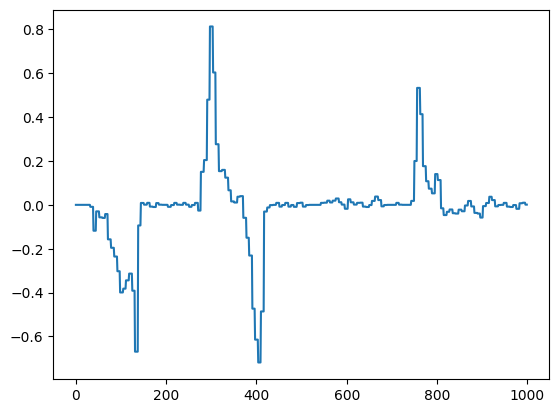

In [48]:
data = pd.read_csv('log/data_sensor_new.csv')
data['Velocity X [m/s]'].plot()